# Hackapizza Dataset - Initial Exploratory Analysis

This notebook provides a first-pass exploratory analysis for the data under `Hackapizza Dataset/`.

It covers:
- file inventory and basic metadata
- `domande.csv` text analysis
- `Misc/Distanze.csv` matrix checks and visualization
- `Misc/dish_mapping.json` analysis
- extraction of key signals from blogpost HTML files


In [3]:
from pathlib import Path
import json
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_colwidth", 180)
sns.set_theme(style="whitegrid")

DATA_ROOT = Path("Hackapizza Dataset")
assert DATA_ROOT.exists(), f"Path not found: {DATA_ROOT.resolve()}"
DATA_ROOT.resolve()

PosixPath('/Users/lorenzomelchionna/Personal/datapizza_ht_25/Hackapizza Dataset')

## 1) File Inventory

Useful to quickly understand what data types are available.

In [4]:
all_files = sorted([p for p in DATA_ROOT.rglob("*") if p.is_file()])

inventory = pd.DataFrame(
    {
        "relative_path": [str(p.relative_to(DATA_ROOT)) for p in all_files],
        "suffix": [p.suffix.lower() for p in all_files],
        "size_kb": [round(p.stat().st_size / 1024, 2) for p in all_files],
    }
)

display(inventory.head(20))
print(f"Total files: {len(inventory)}")
print("\nFile types:")
display(inventory["suffix"].value_counts().rename_axis("suffix").to_frame("count"))

,relative_path,suffix,size_kb
0,Blogpost/blog_etere_del_gusto.html,.html,2.30
1,Blogpost/blog_sapore_del_dune.html,.html,3.53
2,Codice Galattico/Codice Galattico.docx,.docx,241.76
3,Codice Galattico/Codice Galattico.pdf,.pdf,283.28
4,Menu/Anima Cosmica.pdf,.pdf,53.12
5,Menu/Armonia Universale.pdf,.pdf,30.67
6,Menu/Cosmica Essenza.pdf,.pdf,29.82
7,Menu/Datapizza.pdf,.pdf,56994.13
8,Menu/Eco di Pandora.pdf,.pdf,53.55
9,Menu/Eredita Galattica.pdf,.pdf,57.83


Total files: 39

File types:


,count
suffix,
.pdf,32
.html,2
.csv,2
.docx,1
.json,1
.png,1


## 2) `domande.csv` - Questions Dataset

Basic quality checks and text-level EDA.

(100, 1)


,domanda
0,Quali sono i piatti che includono le Chocobo Wings come ingrediente?
1,Quali piatti dovrei scegliere per un banchetto a tema magico che includa le celebri Cioccorane?
2,Quali sono i piatti della galassia che contengono Latte+?
3,Quali piatti contengono i Ravioli al Vaporeon?
4,Quali sono i piatti che includono i Sashimi di Magikarp?


,missing
domanda,0


,count,mean,std,min,25%,50%,75%,max
text_len,100.0,146.43,44.832630,46.0,113.75,144.5,180.25,249.0
word_count,100.0,21.43,6.972174,7.0,17.00,20.0,26.00,38.0


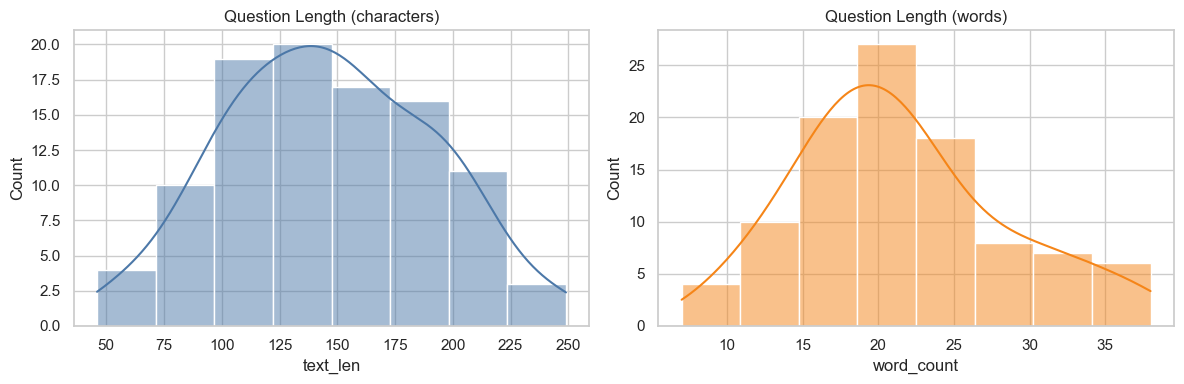

In [5]:
domande_path = DATA_ROOT / "domande.csv"
df_q = pd.read_csv(domande_path)

print(df_q.shape)
display(df_q.head())
display(df_q.isna().sum().to_frame("missing"))

df_q["text_len"] = df_q["domanda"].str.len()
df_q["word_count"] = df_q["domanda"].str.split().str.len()

display(df_q[["text_len", "word_count"]].describe().T)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df_q["text_len"], kde=True, ax=axes[0], color="#4c78a8")
axes[0].set_title("Question Length (characters)")
sns.histplot(df_q["word_count"], kde=True, ax=axes[1], color="#f58518")
axes[1].set_title("Question Length (words)")
plt.tight_layout()
plt.show()

,count
domanda,
piatti,100
preparati,42
tecnica,35
utilizzando,23
cottura,20
almeno,19
ristorante,18
licenza,18
includono,16


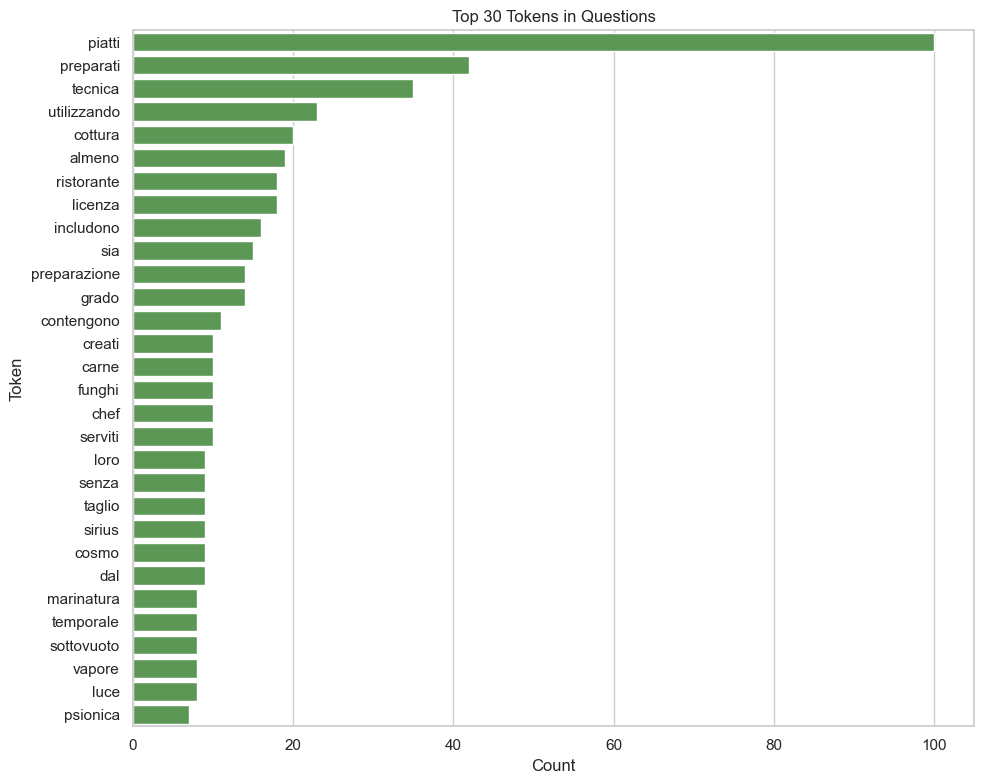

In [6]:
stopwords_it = {
    "di", "a", "da", "in", "con", "su", "per", "tra", "fra", "e", "o", "il", "lo", "la", "i", "gli", "le",
    "un", "una", "uno", "del", "della", "dei", "delle", "dello", "al", "alla", "ai", "agli", "alle",
    "che", "sono", "quali", "quale", "nel", "nella", "nello", "nei", "nelle", "non", "utilizzano", "usano"
}

tokens = (
    df_q["domanda"]
    .str.lower()
    .str.replace(r"[^\w\s']", " ", regex=True)
    .str.split()
    .explode()
)
tokens = tokens[tokens.str.len() > 2]
tokens = tokens[~tokens.isin(stopwords_it)]

top_tokens = tokens.value_counts().head(30)
display(top_tokens.to_frame("count"))

plt.figure(figsize=(10, 8))
sns.barplot(x=top_tokens.values, y=top_tokens.index, orient="h", color="#54a24b")
plt.title("Top 30 Tokens in Questions")
plt.xlabel("Count")
plt.ylabel("Token")
plt.tight_layout()
plt.show()

## 3) `Misc/Distanze.csv` - Planet Distance Matrix

,Tatooine,Asgard,Namecc,Arrakis,Krypton,Pandora,Cybertron,Ego,Montressosr,Klyntar
/,,,,,,,,,,
Tatooine,0,695,641,109,661,1130,344,835,731,530
Asgard,695,0,550,781,188,473,493,156,240,479
Namecc,641,550,0,651,367,987,728,688,767,845
Arrakis,109,781,651,0,727,1227,454,926,834,640
Krypton,661,188,367,727,0,626,557,321,422,599


Shape: (10, 10)
Square matrix: True
Same labels on rows/cols: True
Symmetric: True
Zero diagonal: True


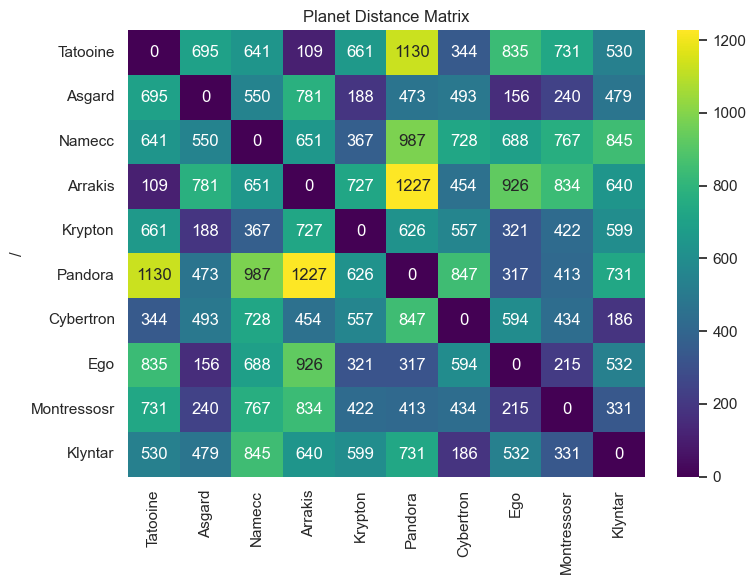

In [7]:
dist_path = DATA_ROOT / "Misc" / "Distanze.csv"
dist_df = pd.read_csv(dist_path, index_col=0)

display(dist_df.head())
print(f"Shape: {dist_df.shape}")

# Basic consistency checks for a distance matrix.
is_square = dist_df.shape[0] == dist_df.shape[1]
same_index_cols = list(dist_df.index) == list(dist_df.columns)
symmetric = np.allclose(dist_df.values, dist_df.values.T)
diag_zero = np.allclose(np.diag(dist_df.values), 0)

print("Square matrix:", is_square)
print("Same labels on rows/cols:", same_index_cols)
print("Symmetric:", symmetric)
print("Zero diagonal:", diag_zero)

plt.figure(figsize=(8, 6))
sns.heatmap(dist_df, cmap="viridis", annot=True, fmt=".0f")
plt.title("Planet Distance Matrix")
plt.tight_layout()
plt.show()

## 4) `Misc/dish_mapping.json` - Dish Name Mapping

In [8]:
mapping_path = DATA_ROOT / "Misc" / "dish_mapping.json"
with open(mapping_path, "r", encoding="utf-8") as f:
    dish_mapping = json.load(f)

map_df = pd.DataFrame(
    {
        "dish_name": list(dish_mapping.keys()),
        "dish_id": list(dish_mapping.values()),
    }
)

display(map_df.head())
print(f"Total mapped dishes: {len(map_df)}")
print("Unique IDs:", map_df["dish_id"].nunique())
print("Min ID:", map_df["dish_id"].min(), "| Max ID:", map_df["dish_id"].max())

dupe_names = map_df["dish_name"].duplicated().sum()
dupe_ids = map_df["dish_id"].duplicated().sum()
print("Duplicate names:", dupe_names)
print("Duplicate IDs:", dupe_ids)

map_df["name_len"] = map_df["dish_name"].str.len()
display(map_df["name_len"].describe().to_frame("name_len_stats"))

,dish_name,dish_id
0,Alternate Realities Risotto,0
1,Antipasto Celestiale,1
2,Antipasto Stellare dell'Eterna Armonia,2
3,Armonia Cosmica alla Tavola d'Oro,3
4,Armonia Cosmica della Fenice,4


Total mapped dishes: 287
Unique IDs: 287
Min ID: 0 | Max ID: 286
Duplicate names: 0
Duplicate IDs: 0


,name_len_stats
count,287.000000
mean,31.505226
std,15.217737
min,9.000000
25%,21.000000
50%,29.000000
75%,37.000000
max,127.000000


## 5) Blogpost HTML Parsing

This extracts:
- title
- rating (if present in text like `Voto: x/y`)
- ingredient percentages mentioned in the article


In [11]:
blog_dir = DATA_ROOT / "Blogpost"
blog_files = sorted(blog_dir.glob("*.html"))

def html_to_plain_text(html):
    # Prefer BeautifulSoup if installed; otherwise use a simple regex fallback.
    try:
        from bs4 import BeautifulSoup
        soup = BeautifulSoup(html, "html.parser")
        return soup.get_text(" ", strip=True)
    except Exception:
        return re.sub(r"<[^>]+>", " ", html)

rows = []
for path in blog_files:
    html = path.read_text(encoding="utf-8")
    text = html_to_plain_text(html)

    title_match = re.search(r"<h2[^>]*>(.*?)</h2>", html, flags=re.IGNORECASE | re.DOTALL)
    title = re.sub(r"\s+", " ", title_match.group(1)).strip() if title_match else path.stem
    title = re.sub(r"<[^>]+>", "", title)
    title = (
        title.replace("&#39;", "'")
        .replace("&quot;", '"')
        .replace("&amp;", "&")
    )

    rating_match = re.search(r"voto\s*:\s*([0-9]+(?:[\.,][0-9]+)?)\s*/\s*([0-9]+)", text, flags=re.IGNORECASE)
    rating_num = np.nan
    rating_den = np.nan
    if rating_match:
        rating_num = float(rating_match.group(1).replace(",", "."))
        rating_den = float(rating_match.group(2))

    perc_mentions = re.findall(r"([0-9]+(?:[\.,][0-9]+)?)\s*%", text)
    perc_mentions = [float(x.replace(",", ".")) for x in perc_mentions]

    rows.append(
        {
            "file": path.name,
            "title": title,
            "rating_num": rating_num,
            "rating_den": rating_den,
            "n_percentage_mentions": len(perc_mentions),
            "percentage_mentions": perc_mentions,
            "text_length": len(text),
        }
    )

blog_df = pd.DataFrame(rows)
display(blog_df)

if blog_df["rating_num"].notna().any():
    blog_df["rating_norm_10"] = blog_df["rating_num"] / blog_df["rating_den"] * 10
    display(blog_df[["file", "title", "rating_num", "rating_den", "rating_norm_10"]])

,file,title,rating_num,rating_den,n_percentage_mentions,percentage_mentions,text_length
0,blog_etere_del_gusto.html,L'Etere del Gusto: Quando la Divinità Culinaria Precipita sulla Terra,1.5,10.0,3,"[8.0, 3.0, 2.0]",2028
1,blog_sapore_del_dune.html,Sapore del Dune: Quando l'Ambizione Supera l'Esecuzione,2.0,10.0,9,"[1.0, 0.1, 1.0, 1.0, 0.1, 3.0, 0.1, 2.0, 2.0]",3253


,file,title,rating_num,rating_den,rating_norm_10
0,blog_etere_del_gusto.html,L'Etere del Gusto: Quando la Divinità Culinaria Precipita sulla Terra,1.5,10.0,1.5
1,blog_sapore_del_dune.html,Sapore del Dune: Quando l'Ambizione Supera l'Esecuzione,2.0,10.0,2.0


## Next Steps

For a deeper EDA, you can extend this notebook with:
- parsing menu PDFs into a structured dish-level table (restaurant, ingredients, techniques, planet)
- linking `domande.csv` entities to extracted dish metadata
- building baseline retrieval / rule-based query matching checks
